# Text-to-Speech toolchains



In [2]:
! pip install tensorboard

Defaulting to user installation because normal site-packages is not writeable
Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [5]:
! tensorboard --logdir='/tb_logs/TestRun'

TensorFlow installation not found - running with reduced feature set.

NOTE: Using experimental fast data loading logic. To disable, pass
    "--load_fast=false" and report issues on GitHub. More details:
    https://github.com/tensorflow/tensorboard/issues/4784

TensorBoard 2.7.0 at http://2bd1dcdfba09:6006/ (Press CTRL+C to quit)
^C


# Speech Synthesis using Neural-HMM

## Summary

We show that classic, HMM-based speech synthesis and modern, neural text-to-speech (TTS) can be combined to obtain the best of both worlds. Concretely, our proposal amounts to replacing conventional attention in neural TTS by so-called neural HMMs. We call this new approach “neural HMM TTS”.

To validate our proposal, we describe a modified version of Tacotron 2 that uses neural HMMs instead of attention. The resulting system:
* Is smaller and simpler than Tacotron 2
* Learns to speak and align much quicker
* Does not risk breaking down into gibberish
* Is fully probabilistic
* Allows easy control over speaking rate
* Achieves the same naturalness as Tacotron 2

To our knowledge, this is the first time HMM-based speech synthesis has achieved a speech quality on par with neural TTS.

For more information, please [read our ICASSP 2022 paper here](https://arxiv.org/abs/2108.13320).

## Architecture

![Synthesis speech from Neural-HMM](docs/images/NeuralHMMTTS.png)


## Import libraries and setup matplotlib

In [1]:
import matplotlib.pylab as plt

# Download tokenizer if not present
import nltk
nltk.download('punkt')

import IPython.display as ipd 
import os
import json
import sys
sys.path.append('src/model')
sys.path.insert(0, './hifigan')
import numpy as np
import torch
import soundfile as sf
from pathlib import Path

from src.hparams import create_hparams
from src.training_module import TrainingModule
from src.utilities.text import text_to_sequence, phonetise_text
from hifigan.env import AttrDict
from hifigan.models import Generator
from nltk import word_tokenize
%matplotlib inline


[nltk_data] Downloading package punkt to /home/ubuntu/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/home/ubuntu/miniconda3/envs/tts/lib/python3.7/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(torch.__version__)
print(device)

1.7.0
cuda


## Helper functions

In [3]:
#to plot spectogram 
def plot_spectrogram_to_numpy(spectrogram):
    fig, ax = plt.subplots(figsize=(12, 3))
    im = ax.imshow(spectrogram, aspect="auto", origin="lower",
                   interpolation='none')
    plt.colorbar(im, ax=ax)
    plt.xlabel("Frames")
    plt.ylabel("Channels")
    plt.title("Synthesised Mel-Spectrogram")
    fig.canvas.draw()
    plt.show()
    
def plot_hidden_states(hidden_states):
    plt.plot(hidden_states_travelled)
    plt.xlabel("Time steps")
    plt.ylabel("HMM states")
    plt.title("Hidden states vs Time")
    plt.show()

def load_checkpoint(filepath, device):
    print(filepath)
    assert os.path.isfile(filepath)
    print("Loading '{}'".format(filepath))
    checkpoint_dict = torch.load(filepath, map_location=device)
    print("Complete.")
    return checkpoint_dict    

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

## Setup hparams and Load the models

In [4]:
#Set path variables for the checkpoints
checkpoint_path = "checkpoints/TestRun/checkpoint_201000.ckpt"
hifigan_loc = 'hifigan/'

#Setup hparams
hparams = create_hparams()

#Load pre-trained LJ Speech model
model = TrainingModule.load_from_checkpoint(checkpoint_path)
_ = model.to(device).eval().half()

#Load Hifi-gan for mel2audio synthesis and denoiser
config_file = hifigan_loc + 'config.json'
hifi_checkpoint_file = hifigan_loc + 'generator_v1'
with open(config_file) as f:
    data = f.read()
json_config = json.loads(data)

h = AttrDict(json_config)
torch.manual_seed(h.seed)
generator = Generator(h).to(device)
state_dict_g = load_checkpoint(hifi_checkpoint_file, device)
generator.load_state_dict(state_dict_g['generator'])
generator.eval()
generator.remove_weight_norm()

hifigan/generator_v1
Loading 'hifigan/generator_v1'
Complete.
Removing weight norm...


## Initialise Hyperparameters

### Usage
1. Increase max_sampling_time for longer utterances
2. Increase duration_quantile_threshold for faster speaking rate
3. Set deterministic_transaction as False for model sampled transition probabilities
4. Set predict_means to False to synthesis a sample instead of just means of gaussians
5. Set prenet_dropout_while_eval to False to turn off dropout in the prenet module

In [5]:
model.model.hmm.hparams.max_sampling_time = 1800
model.model.hmm.hparams.duration_quantile_threshold=0.42
model.model.hmm.hparams.deterministic_transition=True
model.model.hmm.hparams.predict_means=True
model.model.hmm.hparams.prenet_dropout_while_eval=True

# 1. Text Preprocessing

In [6]:
texts = [
"William Shakespeare was an English poet, playwright and actor, widely regarded as the greatest writer in the English language and the world’s greatest dramatist. He is often called England’s national poet and the ‘Bard of Avon"
]

sequences = []

for i, text in enumerate(texts):
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Input text: \n{''.join(['*'] * 20)}\n{text}")
    text = phonetise_text(hparams.cmu_phonetiser, text, word_tokenize)
    print(f"\n{''.join(['*'] * 20)}\n{i + 1} - Phonetised text: \n{''.join(['*'] * 20)}\n{text}")
    sequence = np.array(text_to_sequence(text, ['english_cleaners']))[None, :]
    sequence = torch.from_numpy(sequence).to(device).long()
    sequences.append(sequence)
    
    print(''.join(['='] * 100))


********************
1 - Input text: 
********************
William Shakespeare was an English poet, playwright and actor, widely regarded as the greatest writer in the English language and the world’s greatest dramatist. He is often called England’s national poet and the ‘Bard of Avon

********************
1 - Phonetised text: 
********************
{W IH1 L Y AH0 M} {SH EY1 K S P IY2 R} {W AA1 Z} {AE1 N} {IH1 NG G L IH0 SH} {P OW1 AH0 T} , {P L EY1 R AY2 T} {AH0 N D} {AE1 K T ER0} , {W AY1 D L IY0} {R IH0 G AA1 R D IH0 D} {AE1 Z} {DH AH0} {G R EY1 T AH0 S T} {R AY1 T ER0} {IH0 N} {DH AH0} {IH1 NG G L IH0 SH} {L AE1 NG G W AH0 JH} {AH0 N D} {DH AH0} {W ER1 L D} ’ {EH1 S} {G R EY1 T AH0 S T} {D R AA1 M AH0 T IH0 S T} . {HH IY1} {IH1 Z} {AO1 F T AH0 N} {K AO1 L D} {IH1 NG G L AH0 N D} ’ {EH1 S} {N AE1 SH AH0 N AH0 L} {P OW1 AH0 T} {AH0 N D} {DH AH0} ‘ {B AA1 R D} {AH1 V} {EY1 V AA0 N}


# 2. Spectrogram Generation

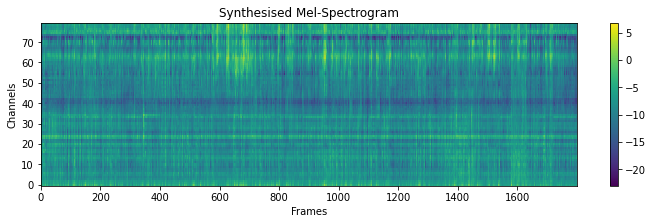

In [7]:
with torch.no_grad():
    mel_outputs, hidden_state_travelled_all = [], []
    for sequence in sequences:
        mel_output, hidden_state_travelled = model.inference(sequence)
        mel_outputs.append(mel_output)
        hidden_state_travelled_all.append(hidden_state_travelled)

#Visualisations of the output
for mel_output in mel_outputs:
    plot_spectrogram_to_numpy(np.array(mel_output).T)

# 3. Vocoder transforming mel-spectrogram to waveform using WaveGlow

In [8]:
with torch.no_grad():
    audios = []
    for i, mel_output in enumerate(mel_outputs):
        mel_output = torch.tensor(mel_output).T.unsqueeze(0).cuda().float()
        audio = generator(mel_output)
        audios.append(audio)
        print(f"{''.join(['*'] * 10)} \t{i + 1}\t {''.join(['*'] * 10)}")
        print(f"Text: {texts[i]}")
        ipd.display(ipd.Audio(audio[0].data.cpu().numpy(), rate=hparams.sampling_rate))
        print(f"{''.join(['*'] * 35)}\n")


********** 	1	 **********
Text: William Shakespeare was an English poet, playwright and actor, widely regarded as the greatest writer in the English language and the world’s greatest dramatist. He is often called England’s national poet and the ‘Bard of Avon


***********************************



### 3.1 Save to wav files using soundfile

In [ ]:

basepath = Path('synthesised_wavs')
basepath.mkdir(parents=True, exist_ok=True)

for i, audio in enumerate(audios):
    filename = basepath / f'syn_{i + 1}.wav'
    sr = 22500
    sf.write(filename, audio.data.squeeze().cpu().numpy(), 
             22500, 'PCM_24')
    print(f'Successfully written: {filename}')
